In [3]:
pip install --upgrade aicspylibczi

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
from aicspylibczi import CziFile
from pathlib import Path
import matplotlib.pyplot as plt

pth = Path('MUT_Sample_New-01_AcquisitionBlock8.czi')
czi = CziFile(pth)

czi.dims, czi.size

('HSTCZYX', (1, 1, 121, 1, 29, 1024, 1024))

In [4]:
data, shape_dict = czi.read_image()

In [5]:
shape_dict

[('H', 1), ('S', 1), ('T', 121), ('C', 1), ('Z', 29), ('Y', 1024), ('X', 1024)]

#### For reference: 
- The full volume[0] = z-stack at t=0
- volume[0][0] = slice at z=0, t=0  **(first slice along the depth (z-axis) at t=0)**
- volume[0][28] = slice at z=28, t=0 **(last slice along the depth (z-axis) at t=0)**

In [6]:
volumes = []  # list to hold 3D volumes

for t in range(shape_dict[2][1]):
    stack = data[0, 0, t, 0, :, :, :]  # shape: [Z, Y, X] = [29, 1024, 1024]
    volumes.append(stack)

In [7]:
import os
os.makedirs("zstacks", exist_ok=True)

for t, volume in enumerate(volumes):
    filename = f"zstacks/sample_t{t:03d}.npy"
    np.save(filename, volume)
    break

In [8]:
import numpy as np
import matplotlib.pyplot as plt

volume = np.load("zstacks/sample_t000.npy")  # shape: [Z, Y, X]
print(volume.shape)

(29, 1024, 1024)


#### The observed right-skewed distribution of pixel intensities is expected in fluorescence microscopy. The majority of the image volume is background with low or near-zero intensity, while a small subset of pixels—corresponding to labeled cellular structures—exhibit high fluorescence, leading to a long-tailed intensity distribution.

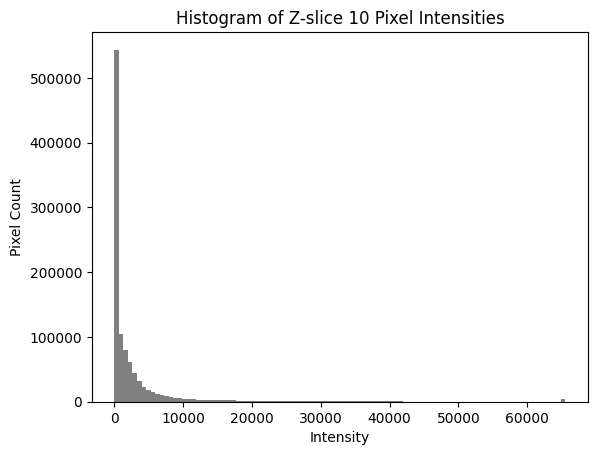

In [9]:
plt.hist(volume[0].ravel(), bins=100, color='gray')
plt.title("Histogram of Z-slice 10 Pixel Intensities")
plt.xlabel("Intensity")
plt.ylabel("Pixel Count")
plt.show() 

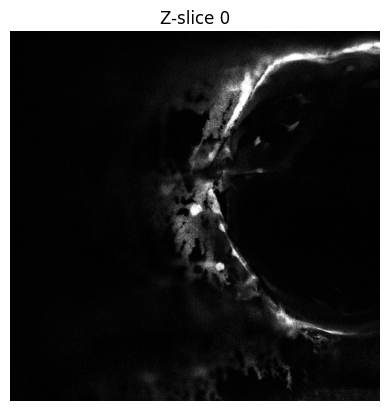

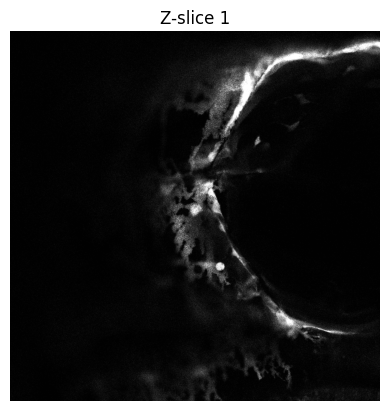

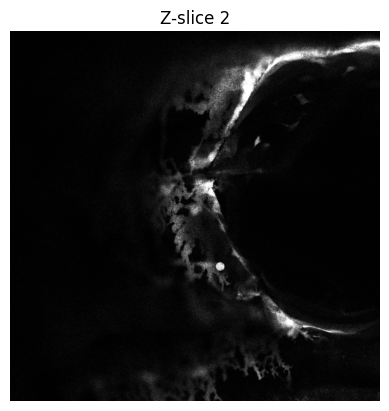

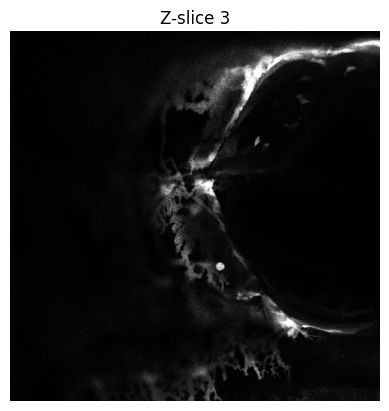

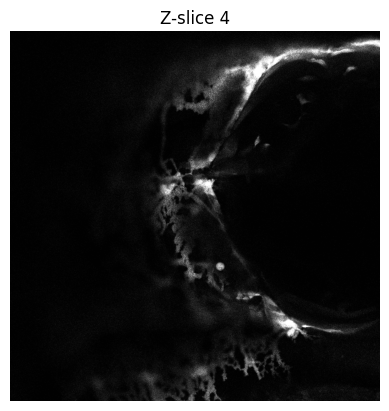

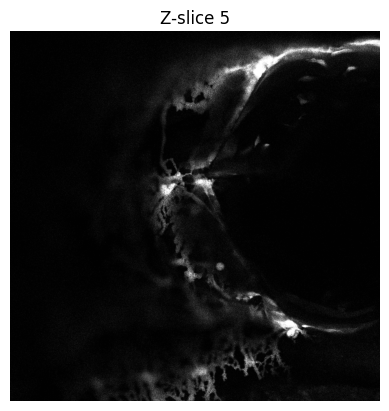

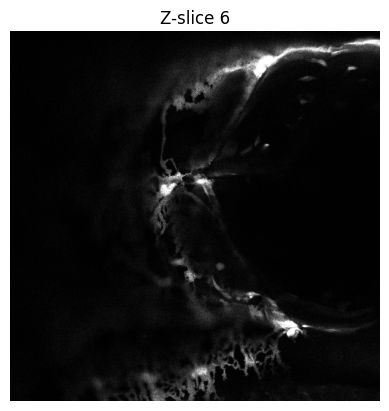

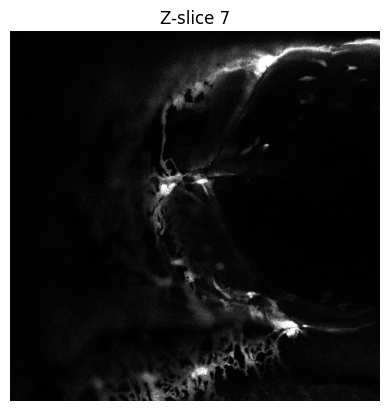

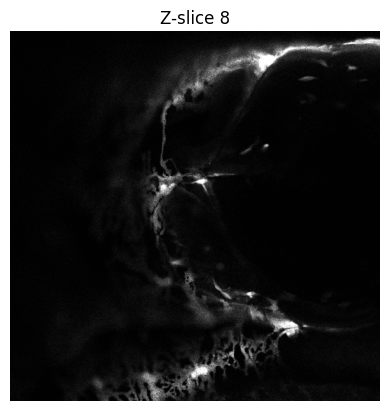

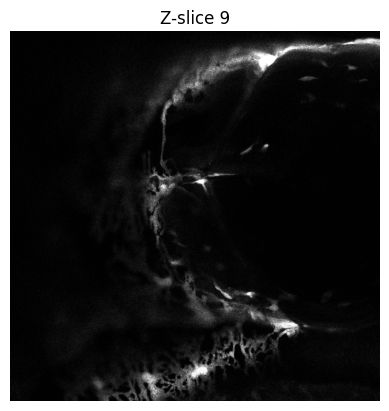

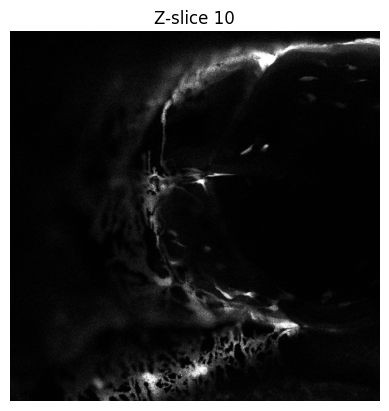

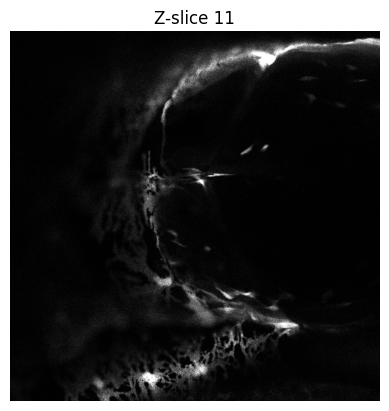

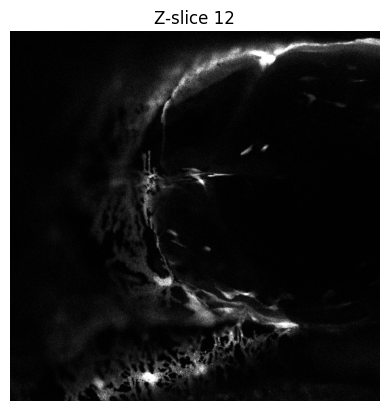

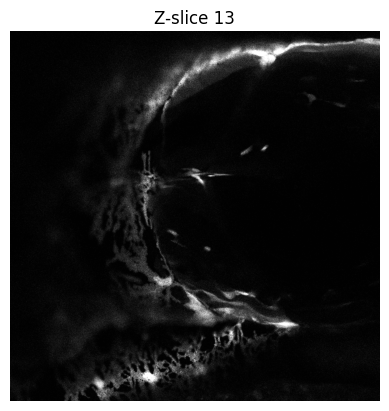

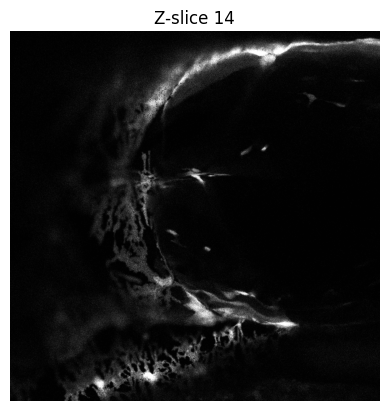

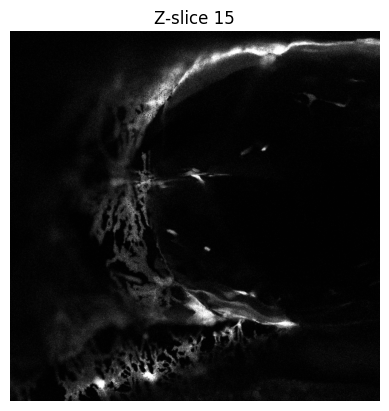

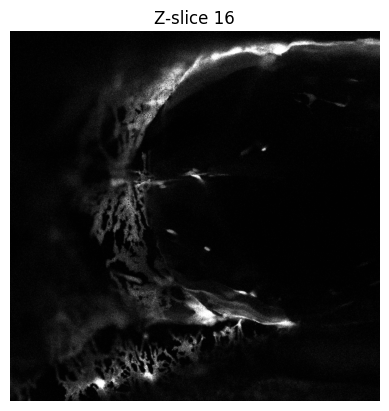

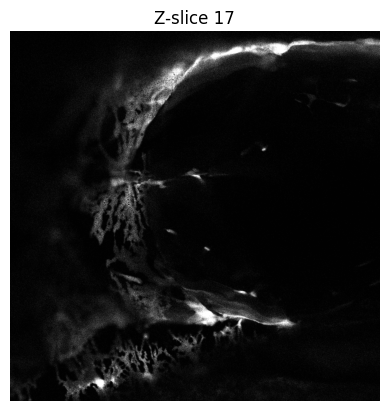

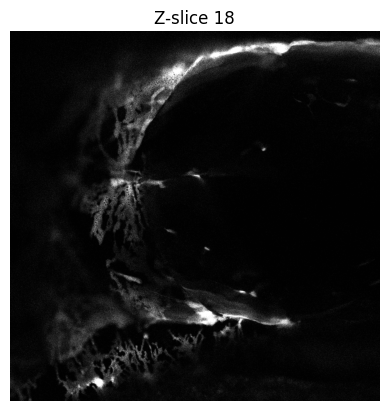

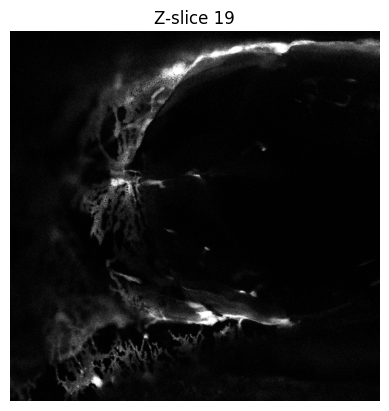

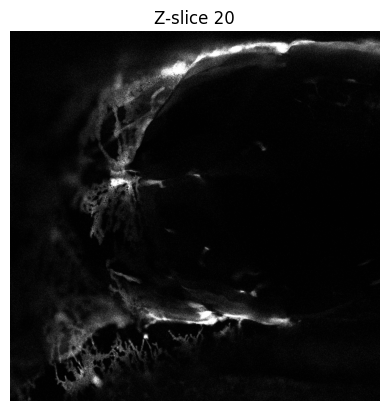

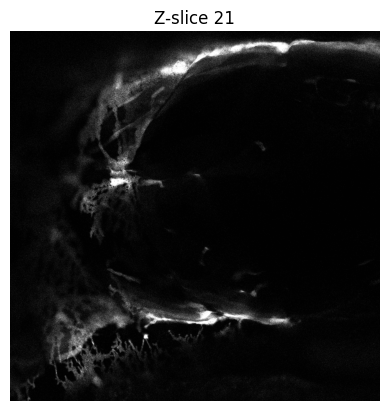

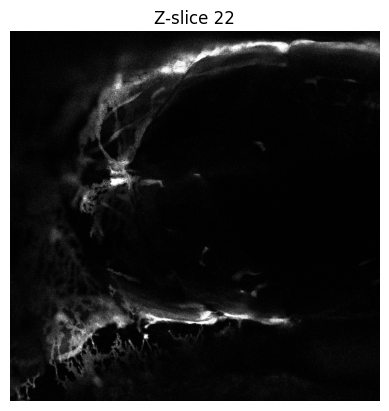

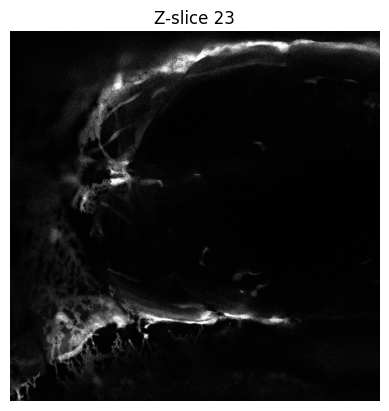

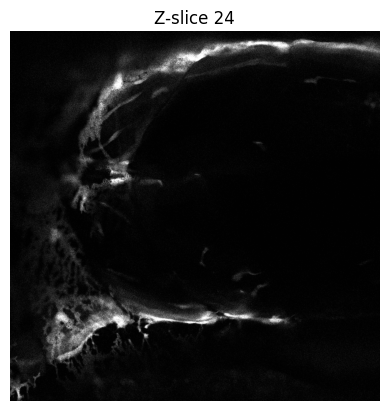

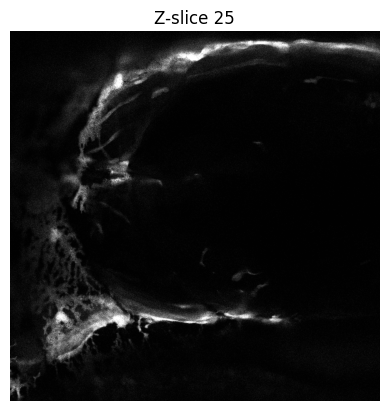

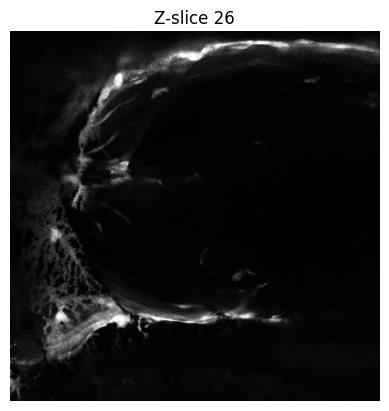

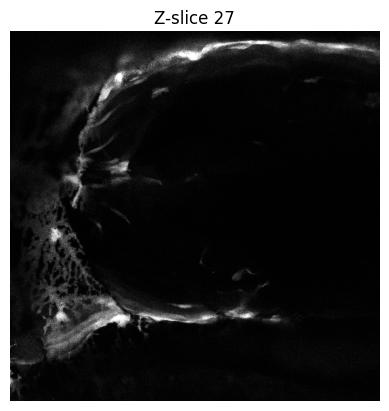

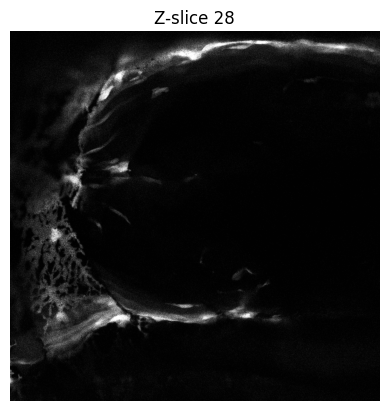

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
import time

for i in range(volume.shape[0]):
    plt.imshow(volume[i], cmap='gray')
    plt.title(f"Z-slice {i}")
    plt.axis('off')
    plt.pause(0.1)
    plt.clf()

#### Bimodal distribution: clustered low-intensity background (left peak) and more variable, spread-out high-intensity foreground (right peak) — indicating strong structural contrast suitable for contrastive learning. This helps prevent bright outliers from dominating model training

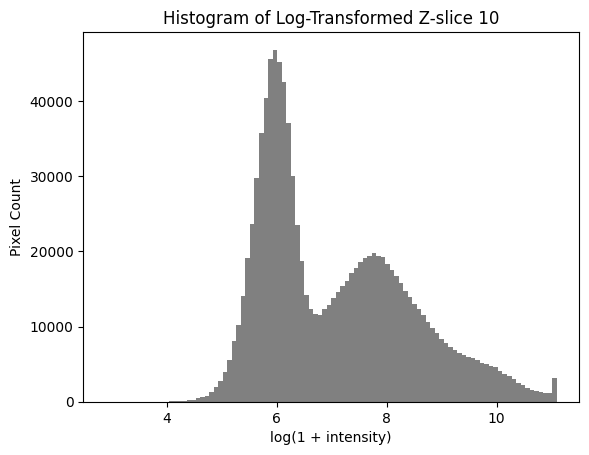

In [13]:
import numpy as np
import matplotlib.pyplot as plt

log_norm = np.log1p(volume[10])  

plt.hist(log_norm.ravel(), bins=100, color='gray')
plt.title("Histogram of Log-Transformed Z-slice 10")
plt.xlabel("log(1 + intensity)")
plt.ylabel("Pixel Count")
plt.show() # going to apply it  in my TorchIO transform during training!!

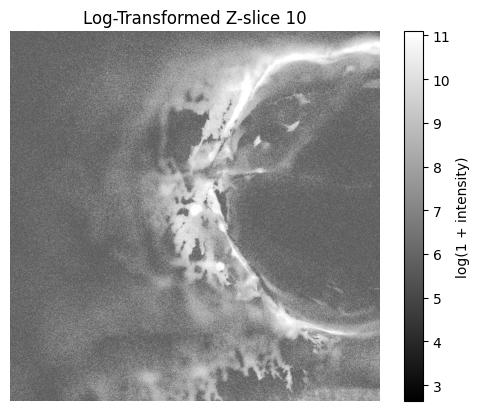

In [14]:
import matplotlib.pyplot as plt
log_norm = np.log1p(volume[0])

plt.imshow(log_norm, cmap='gray')
plt.title("Log-Transformed Z-slice 10")
plt.axis('off')
plt.colorbar(label='log(1 + intensity)')
plt.show()

In [2]:
# Final code for creating a dataset .npy
import numpy as np
from aicspylibczi import CziFile
from pathlib import Path
import os

czi_paths = [
    "MUT_Sample_New-01_AcquisitionBlock8.czi",
    "MUT_New-01_AcquisitionBlock4.czi",
    "MUT New-01_AcquisitionBlock2.czi",
    "WT New-01_AcquisitionBlock4.czi",
    "WT_Sample_New-01_AcquisitionBlock2.czi",
    "WT New-01_AcquisitionBlock3.czi"
]

for file in czi_paths:
    pth = Path(file)
    safe_name = str(pth.stem).replace(" ", "_") 
    out_dir = Path("zstacks") / safe_name
    os.makedirs(out_dir, exist_ok=True)

    try:
        czi = CziFile(pth)
        data, shape_dict = czi.read_image()
    except Exception as e:
        print(f"Failed to load {file}: {e}")
        continue

    volumes = []
    for t in range(shape_dict[2][1]):  # shape_dict[2] = ('T', num_timepoints)
        try:
            stack = data[0, 0, t, 0, :, :, :]  # shape: [Z, Y, X]
            volumes.append(stack)
        except Exception as e:
            print(f"Failed to extract timepoint {t} from {safe_name}: {e}")

    for t, volume in enumerate(volumes):
        try:
            filename = out_dir / f"sample_t{t:03d}.npy"
            np.save(filename, volume)
        except Exception as e:
            print(f"Failed to save timepoint {t} in {safe_name}: {e}")

    print(f"✅ Processed: {file} → saved {len(volumes)} z-stacks.")

✅ Processed: MUT_Sample_New-01_AcquisitionBlock8.czi → saved 121 z-stacks.
✅ Processed: MUT_New-01_AcquisitionBlock4.czi → saved 65 z-stacks.
✅ Processed: MUT New-01_AcquisitionBlock2.czi → saved 65 z-stacks.
✅ Processed: WT New-01_AcquisitionBlock4.czi → saved 121 z-stacks.
Failed to save timepoint 121 in WT_Sample_New-01_AcquisitionBlock2: 42991616 requested and 0 written
✅ Processed: WT_Sample_New-01_AcquisitionBlock2.czi → saved 122 z-stacks.
✅ Processed: WT New-01_AcquisitionBlock3.czi → saved 121 z-stacks.


In [16]:
import os
os.path.getsize("WT New-01_AcquisitionBlock3.czi") / (1024**3)  # size in GB

10.881533145904541

In [19]:
import czifile

try:
    img = czifile.imread("WT New-01_AcquisitionBlock3.czi")
    print("czifile loaded it successfully:", img.shape)
except Exception as e:
    print("czifile failed:", e)

czifile loaded it successfully: (1, 1, 121, 1, 46, 1024, 1024, 1)


In [20]:
print(img.shape)

(1, 1, 121, 1, 46, 1024, 1024, 1)


In [21]:
import numpy as np
import os
from pathlib import Path
import czifile

# Load and squeeze
img = czifile.imread("WT New-01_AcquisitionBlock3.czi")
img = np.squeeze(img)  # Result: [121, 46, 1024, 1024]
print("Final shape:", img.shape)

# Output folder
out_dir = Path("zstacks/WT_New-01_AcquisitionBlock3_FIXED")
os.makedirs(out_dir, exist_ok=True)

# Save z-stacks
for t in range(img.shape[0]):  # loop over time
    volume = img[t]  # shape: [Z, Y, X]
    np.save(out_dir / f"sample_t{t:03d}.npy", volume)

print(f"✅ Recovered and saved {img.shape[0]} z-stacks from WT_New-01_AcquisitionBlock3.czi")

Final shape: (121, 46, 1024, 1024)
✅ Recovered and saved 121 z-stacks from WT_New-01_AcquisitionBlock3.czi
